# DO MORE GUNS = MORE FREEDOM?

This notebook demonstrates transformation and exploration of data on global firearm ownership, firearm and police fatalities and freedom indices. 

It is no surprise by now that the US is a serious outlier regarding gun ownership, gun laws (or the lack thereof) and overall firearm-related violence and deaths compared to other developed countries. So I decided to look into the data for the rest of the world first to see if any overall trends can be estabilished. The three main questions I'm looking to answer with this exploratory analysis are:
1. Is there evidence for correlation between the firearm and police death rates with firearm ownership rates?
2. Are there trends in the death rates by firearm and police with respect to how developed a country is? 
3. Does firearm ownership grant more personal freedom?

## Data

- **IHME-GBD data set** - the data set is generated using the GBD Results tool, (citation: Global Burden of Disease Collaborative Network. Global Burden of Disease Study 2019 (GBD 2019) Results. Seattle, United States: Institute for Health Metrics and Evaluation (IHME), 2020. Available from http://ghdx.healthdata.org/gbd-results-tool.). Contains firearm-related, police-related and other death rates per country, per year for years 2013-2019, grouped by age group, sex and cause.
- **global gun ownership** - downloaded from Wikipedia https://en.wikipedia.org/wiki/Gun_ownership / the Small Arms Survey for 2017
- **freedom index** - data from the latest report of the Cato Institute, downloaded from Kaggle https://www.kaggle.com/gsutters/the-human-freedom-index?select=hfi_cc_2020.csv (most recent year available in the data set is 2017)

*The above data can be found as .csv files in the raw_data/ folder*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

## Data wrangling

### Transform the IHME-GBD data

In [2]:
df_ihme = pd.read_csv('raw_data/IHME-GBD_2019_DATA.csv')
df_ihme.head()

,measure,location,sex,age,cause,metric,year,val,upper,lower
0,Deaths,Peru,Male,All Ages,Self-harm by firearm,Number,2013,37.707543,52.778423,17.774173
1,Deaths,Peru,Female,All Ages,Self-harm by firearm,Number,2013,5.738864,7.510162,4.284653
2,Deaths,Peru,Male,All Ages,Self-harm by firearm,Percent,2013,0.000489,0.000685,0.000239
3,Deaths,Peru,Female,All Ages,Self-harm by firearm,Percent,2013,0.000087,0.000110,0.000068
4,Deaths,Peru,Male,All Ages,Self-harm by firearm,Rate,2013,0.244087,0.341644,0.115055


We can immediately see that the above table is not very helpful for exploratory analysis as features like age, sex, cause and metric are all listed as separate rows with corresponding unique values. For my particular questions and assumptions, I do not yet care about stats on different sexes and age groups, but I do care about the country, year and specific cause. So let's transform the data set so that it is more convenient to filter on these features.

In [3]:
def transform_ihme_data(df_in, detailed=False):
    '''
    A function that transforms the IHME data rows into columns corresponding to the different causes and metrics.
    
    INPUT
    -----
    df_in - pandas IHME dataframe with causes, sex, age and metrics stored in rows
    detailed - if true, creates columns separated by age and sex, if false sums over age groups and sexes
    
    OUTPUT
    ------
    df_out - transformed pandas dataframe, such that causes and metrics are stored in separate columns
    '''
    
    # identify the unique countries and years
    countries = df_in['location'].unique()
    years = df_in['year'].unique()
    # generate new table with two columns based on the cartesian product of countries and years
    df_out = pd.DataFrame.from_records(list(itertools.product(countries, years)), columns =['country', 'year'])
    
    # sort by country and year to preserve the same order as all the columns that are going to be added
    df_out = df_out.sort_values(['country', 'year']).reset_index().drop('index', axis=1)
    
    # generate all other necessary columns and initialize them with nans
    # the dictionary keys defined here are used to short-name the columns
    cause_keys = {'self-firearm': 'Self-harm by firearm', 
              'self-other': 'Self-harm by other specified means',
               'violence-firearm': 'Physical violence by firearm',
               'violence-sharp': 'Physical violence by sharp object',
               'violence-other': 'Physical violence by other means',
               'police': 'Executions and police conflict', 
               'unintentional': 'Unintentional firearm injuries',
               'terrorism': 'Conflict and terrorism'}
    
    metric_keys = {'number': 'Number', 'perc': 'Percent', 'rate': 'Rate'}
    
    for metric in metric_keys.keys():
        for cause in cause_keys.keys():
            
            if detailed:
                # groups by sex and age as well instead of marginalizing over them
                age_keys = {'50-90': '50 to 74 years', 
                            '10-24': '10 to 24', 
                            '25-29': '25 to 49', 
                            '75+': '75 plus', 
                            '0-9': '0 to 9'}
    
                sex_keys = {'m': 'Male', 'f': 'Female'}
        
                for age in age_keys.keys():
                    df_filter = (df_in['cause']==cause_keys[cause]) & (df_in['age']==age_keys[age]) & (df_in['metric']==metric_keys[metric])
                    df_out['%s_%s_%s' % (cause, age, metric)] = df_in[df_filter].sort_values(['location', 'year']).groupby(['location', 'year']).sum().reset_index()['val']
                for sex in sex_keys.keys():
                    df_filter = (df_in['cause']==cause_keys[cause]) & (df_in['sex']==sex_keys[sex]) & (df_in['metric']==metric_keys[metric])
                    df_out['%s_%s_%s' % (cause, sex, metric)] = df_in[df_filter].sort_values(['location', 'year']).groupby(['location', 'year']).sum().reset_index()['val']
            
            else:
                df_filter = (df_in['cause']==cause_keys[cause]) & (df_in['metric']==metric_keys[metric])
                df_out['%s_%s' % (cause, metric)] = df_in[df_filter].sort_values(['location', 'year']).groupby(['location', 'year']).sum().reset_index()['val']

    return df_out

In [4]:
df_ihme_tf = transform_ihme_data(df_ihme, detailed=False)
df_ihme_tf.head()

,country,year,self-firearm_number,self-other_number,violence-firearm_number,violence-sharp_number,violence-other_number,police_number,unintentional_number,terrorism_number,...,unintentional_perc,terrorism_perc,self-firearm_rate,self-other_rate,violence-firearm_rate,violence-sharp_rate,violence-other_rate,police_rate,unintentional_rate,terrorism_rate
0,Afghanistan,2013,172.974098,2692.400955,780.357729,789.842519,7186.837875,35.783851,174.612584,23657.634008,...,0.005810,0.812965,5.171030,70.103084,12.431410,13.161331,127.710444,0.995728,3.768440,450.235768
1,Afghanistan,2014,174.339785,2714.164837,777.951659,786.142510,7276.272981,32.041359,171.908139,36015.927162,...,0.005214,1.134994,5.100228,69.097155,12.079067,12.811437,126.052777,0.909710,3.627186,664.745408
2,Afghanistan,2015,177.355686,2756.860693,1462.323749,1013.961017,7601.975505,34.508585,171.706981,47333.601352,...,0.004824,1.387440,5.051065,68.388525,22.595110,16.129857,128.096516,0.936164,3.536791,852.489168
3,Afghanistan,2016,181.668481,2827.823862,1296.711643,971.596797,7796.768567,45.267057,173.452215,56102.000000,...,0.004619,1.568276,5.012669,67.851349,19.298544,14.995783,127.080381,1.095435,3.461555,978.750544
4,Afghanistan,2017,187.018829,2908.444544,1361.209242,1007.288316,8012.530302,886.920278,174.948906,38712.783426,...,0.005012,1.183084,4.986791,67.304260,19.603129,15.050625,126.116602,14.570797,3.371430,652.517637


Perfect! The new dataframe now has each column labeled by the cause and metric keys and we can easily filter and explore them!

Before moving forward, let's also isolate only the data for 2017 since that's the only year we have gun ownership rates for and the latest year we have freedom index data for.

In [5]:
df_ihme_2017 = df_ihme_tf[df_ihme_tf['year']==2017].reset_index().drop(columns=['index'])

### Adding features

#### country codes

When adding more features to the above data set, we need to match the dataframes by the country name. However, different data sources may have different versions of a country's name. For example, "Bahamas", "Bahamas, The", "The Bahamas", "The Commonwealth of The Bahamas", are all valid names for the same country. So it's useful to instead assign a unique code to each country in the separate data sets and use the country code instead of the country name for combining them.

To do this we'll use the CDS Open Geo Dataset (https://coronadatasource.org/open-data/cds-world-countries-open-geo-dataset/) that offers a very convenient table that translates country names (various versions included) to country codes.

In [6]:
geodata = pd.read_csv('raw_data/TranslateCountryNamesToCodes.csv')
geodata.head()

,Forms of country names,Country Name (usual),2char country code,3char country code,Type of match,Possible mismatch
0,Afghanistan,Afghanistan,AF,AFG,Country name,NaN
1,Akrotiri and Dhekelia,United Kingdom,GB,GBR,Country name,NaN
2,?land,Aland Islands,AX,ALA,Country name,NaN
3,Aland Islands,Aland Islands,AX,ALA,Country name,NaN
4,?land Islands,Aland Islands,AX,ALA,Country name,NaN


In [8]:
def add_country_codes(df, geodata, country_column = 'country'):
    '''
    Assigns a country code from the CDS Open Geo Dataset to dataframe with country names.
    
    INPUT
    -----
    df - pandas dataframe to be modified
    geodata - geodata dataset as pandas dataframe with columns for '3char country code' and 'Forms of country names'
    country_column - exact name of the country column in df
    
    OUTPUT
    ------
    df_codes - dataframe with added country_code columns
    
    '''
    df_codes = df.copy()
    country_codes = np.empty(df_codes.shape[0], dtype="U25")
    country_codes[:] = 'nan'
#     df_codes['country_code'] = np.nan
    for i,country in enumerate(df_codes[country_column].values):
        try:
            country_codes[i] = geodata['3char country code'][geodata['Forms of country names']==country].values[0]
        except:
            # if the full name can't be found, try the first word only
            try:
                country_first = country.split(' ')[0]
                country_codes[i] = geodata['3char country code'][geodata['Forms of country names']==country_first].values[0]
            except:
                try:
                    # try the last word
                    country_first = country.split(' ')[-1]
                    country_codes[i] = geodata['3char country code'][geodata['Forms of country names']==country_first].values[0]
                except:
                    try:
                        # names in the form Name, The
                        country_first = country.split(',')[0]
                        country_codes[i] = geodata['3char country code'][geodata['Forms of country names']==country_first].values[0]
                    except:
                        # if none of the above work, print the name for manual lookup in geodata
                        print('{} NO MATCH - Manually find and assign code for {}'.format(i,country))

    
    return country_codes

In [9]:
country_codes = add_country_codes(df_ihme_2017, geodata, country_column='country')

47 NO MATCH - Manually find and assign code for Côte d'Ivoire


There is one country that the function couldn't match, so we need to try to locate it manually (by dropping special characters in this case)

In [10]:
geodata[geodata['Forms of country names']=="Cote d'Ivoire"]

,Forms of country names,Country Name (usual),2char country code,3char country code,Type of match,Possible mismatch
73,Cote d'Ivoire,Cote d'Ivoire,CI,CIV,Country name,NaN


In [11]:
country_codes[47] = 'CIV'
df_ihme_2017['country_code'] = country_codes

Let's finally check if there are any remaining nans in the country codes column:

In [12]:
df_ihme_2017['country_code'].isnull().any()

False

Let's also drop any potential duplicate country codes:

In [13]:
df_ihme_2017=df_ihme_2017.drop_duplicates(subset=['country_code'], keep='first')

In [14]:
df_ihme_2017.head()

,country,year,self-firearm_number,self-other_number,violence-firearm_number,violence-sharp_number,violence-other_number,police_number,unintentional_number,terrorism_number,...,terrorism_perc,self-firearm_rate,self-other_rate,violence-firearm_rate,violence-sharp_rate,violence-other_rate,police_rate,unintentional_rate,terrorism_rate,country_code
0,Afghanistan,2017,187.018829,2908.444544,1361.209242,1007.288316,8012.530302,886.920278,174.948906,38712.783426,...,1.183084,4.986791,67.304260,19.603129,15.050625,126.116602,14.570797,3.371430,652.517637,AFG
1,Albania,2017,54.461033,257.351040,83.660177,17.156939,19.251091,0.651914,7.686850,0.000000,...,0.000000,11.493582,56.505412,15.728801,3.466970,4.486062,0.145138,1.590110,0.000000,ALB
2,Algeria,2017,138.020033,2764.741830,276.608554,121.113692,551.078085,71.005593,99.633571,214.000000,...,0.016572,2.623289,42.464929,3.226813,1.549309,6.858399,1.058640,1.606191,3.269986,DZA
3,American Samoa,2017,0.645391,7.194841,0.413170,0.738425,5.182826,0.012070,0.175987,0.000000,...,0.000000,6.441145,89.248259,5.419256,6.981019,55.884719,0.185149,2.399068,0.000000,ASM
4,Andorra,2017,0.964629,14.660086,0.151278,0.188857,0.572290,0.023679,0.035469,0.000000,...,0.000000,8.776468,112.181799,0.912225,1.195915,3.745676,0.162725,0.297844,0.000000,AND


Awesome, our initial data is ready for more features from other sources!

#### gun ownership

In [15]:
df_gun_ownership = pd.read_csv('raw_data/gun_ownership_2017.csv')
df_gun_ownership.head()

,Country,Firearms,Population,Firearms/100
0,Afghanistan,4270000.0,34169000.0,12.50
1,Albania,350000.0,2911000.0,12.00
2,Algeria,877000.0,41064000.0,2.10
3,American Samoa,400.0,56000.0,0.70
4,Andorra,10000.0,69000.0,14.10


To combine the gun ownership data with the existing IHME dataframe, we need to add a country codes column as well. 

In [16]:
gun_country_codes = add_country_codes(df_gun_ownership, geodata, country_column='Country')

31 NO MATCH - Manually find and assign code for Cabo Verde (Cape Verde)
47 NO MATCH - Manually find and assign code for C�te d'Ivoire (Ivory Coast)
112 NO MATCH - Manually find and assign code for Lao, People's Democratic Republic
156 NO MATCH - Manually find and assign code for Palestinian Territories
165 NO MATCH - Manually find and assign code for Puntland
173 NO MATCH - Manually find and assign code for Saint Martin (France)
177 NO MATCH - Manually find and assign code for S�o Tom� and Principe
185 NO MATCH - Manually find and assign code for Sint Maarten (Netherlands)
190 NO MATCH - Manually find and assign code for Somaliland
224 NO MATCH - Manually find and assign code for Virgin Islands (U.K.)
225 NO MATCH - Manually find and assign code for Virgin Islands (U.S.)


There are more countries with no corresponding codes here and not all of it is due to special characters or unconventional names. 

For example, the "Palestinian territories" typically refers to territories occupied by Israel since 1967 (https://en.wikipedia.org/wiki/Palestinian_territories). However, since there is no country by the name of Palestine in the gun ownership data, we'll assume that Palestinian Territories refers to the State of Palestine. 

In addition, Puntland and Somaliland are both self-declared sovereign states in Somalia and both carry the country code of Somalia. We can assign both the country code for Somalia, but this may pose problems when combining the data sets expecting unique country codes. So we can instead sum up the data from both rows and create a new row for Somalia with the corresponding unique country code.

In [17]:
geodata[(geodata['Forms of country names'] == "Cape Verde")
        | (geodata['Forms of country names'] == "Cote d'Ivoire")
        | (geodata['Forms of country names'] == "Laos")
        | (geodata['Forms of country names'] == "Palestine")
        | (geodata['Forms of country names'] == "Saint Martin")
        | (geodata['Forms of country names'] == "Sao Tome and Principe")
        | (geodata['Forms of country names'] == "Sint Maarten")
        | (geodata['Forms of country names'] == "British Virgin Islands")
        | (geodata['Forms of country names'] == "U.S. Virgin Islands")
        | (geodata['Forms of country names'] == "Somalia")
][['Forms of country names', '3char country code']]

,Forms of country names,3char country code
43,British Virgin Islands,VGB
54,Cape Verde,CPV
73,Cote d'Ivoire,CIV
174,Laos,LAO
235,Palestine,PSE
273,Saint Martin,MAF
281,Sao Tome and Principe,STP
290,Sint Maarten,SXM
295,Somalia,SOM
772,U.S. Virgin Islands,VIR


In [18]:
# 31 NO MATCH - Manually find and assign code for Cabo Verde (Cape Verde)
# 47 NO MATCH - Manually find and assign code for C�te d'Ivoire (Ivory Coast)
# 112 NO MATCH - Manually find and assign code for Lao, People's Democratic Republic
# 156 NO MATCH - Manually find and assign code for Palestinian Territories
# 165 NO MATCH - Manually find and assign code for Puntland
# 173 NO MATCH - Manually find and assign code for Saint Martin (France)
# 177 NO MATCH - Manually find and assign code for S�o Tom� and Principe
# 185 NO MATCH - Manually find and assign code for Sint Maarten (Netherlands)
# 190 NO MATCH - Manually find and assign code for Somaliland
# 224 NO MATCH - Manually find and assign code for Virgin Islands (U.K.)
# 225 NO MATCH - Manually find and assign code for Virgin Islands (U.S.)
missing_indices = [31,47,112,156,173,177,185,224,225]
missing_codes = ['CPV', 'CIV', 'LAO', 'PSE', 'MAF', 'STP', 'SXM', 'VGB', 'VIR']
gun_country_codes[missing_indices] = missing_codes

In [19]:
df_gun_ownership['country_code'] = gun_country_codes

We took care of all the 'easy' country codes, now we just need to clean up the data on the two Somalian territoritories (indices: 165 (Puntland) and 190 (Somaliland)):

In [20]:
somalia_data = {'Country': 'Somalia', 
                'Firearms': df_gun_ownership['Firearms'][165]+df_gun_ownership['Firearms'][190],
                'Population': df_gun_ownership['Population'][165]+df_gun_ownership['Population'][190],
                'Firearms/100': float(df_gun_ownership['Firearms/100'][165])+float(df_gun_ownership['Firearms/100'][190]),
                'country_code': 'SOM'}

In [21]:
df_gun_ownership = df_gun_ownership.append(somalia_data, ignore_index=True).drop([165,190], axis=0)

In [22]:
df_gun_ownership = df_gun_ownership.drop_duplicates(subset=['country_code'], keep='first')

In [23]:
df_gun_ownership.head()

,Country,Firearms,Population,Firearms/100,country_code
0,Afghanistan,4270000.0,34169000.0,12.50,AFG
1,Albania,350000.0,2911000.0,12.00,ALB
2,Algeria,877000.0,41064000.0,2.10,DZA
3,American Samoa,400.0,56000.0,0.70,ASM
4,Andorra,10000.0,69000.0,14.10,AND


Finally, let's combine this dataframe with the IHME data. We'll keep data from both columns because we're doing descriptive analysis. Null values will not cause issues as they would if we were building a machine learning model so it's okay if we have some in this data set.

In [24]:
df_ihme_guns = df_ihme_2017.merge(df_gun_ownership, on='country_code', how='outer').drop(columns=['year'])

In [25]:
df_ihme_guns['Firearms/100'][df_ihme_guns['Firearms/100'] =='<0.1'] = 0.1
df_ihme_guns['firearm-ownership_rate'] = df_ihme_guns['Firearms/100'].astype('float64')*1000

<ipython-input-25-dbb33b60b396>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ihme_guns['Firearms/100'][df_ihme_guns['Firearms/100'] =='<0.1'] = 0.1


In [26]:
df_ihme_guns.head()

,country,self-firearm_number,self-other_number,violence-firearm_number,violence-sharp_number,violence-other_number,police_number,unintentional_number,terrorism_number,self-firearm_perc,...,violence-other_rate,police_rate,unintentional_rate,terrorism_rate,country_code,Country,Firearms,Population,Firearms/100,firearm-ownership_rate
0,Afghanistan,187.018829,2908.444544,1361.209242,1007.288316,8012.530302,886.920278,174.948906,38712.783426,0.005630,...,126.116602,14.570797,3.371430,652.517637,AFG,Afghanistan,4270000.0,34169000.0,12.50,12500.0
1,Albania,54.461033,257.351040,83.660177,17.156939,19.251091,0.651914,7.686850,0.000000,0.073718,...,4.486062,0.145138,1.590110,0.000000,ALB,Albania,350000.0,2911000.0,12.00,12000.0
2,Algeria,138.020033,2764.741830,276.608554,121.113692,551.078085,71.005593,99.633571,214.000000,0.009413,...,6.858399,1.058640,1.606191,3.269986,DZA,Algeria,877000.0,41064000.0,2.10,2100.0
3,American Samoa,0.645391,7.194841,0.413170,0.738425,5.182826,0.012070,0.175987,0.000000,0.017443,...,55.884719,0.185149,2.399068,0.000000,ASM,American Samoa,400.0,56000.0,0.70,700.0
4,Andorra,0.964629,14.660086,0.151278,0.188857,0.572290,0.023679,0.035469,0.000000,0.022900,...,3.745676,0.162725,0.297844,0.000000,AND,Andorra,10000.0,69000.0,14.10,14100.0


#### freedom indices

Finally, let's add the freedom indices. The Kaggle data set is extensive and offers a lot of different indices that relate to the political, religious, justice and economic freedom. Looking into all of these different features is out of the scope of this overview, so we'll only keep the overall freedom index and the personal and economical freedom indices.

In [27]:
df_fi = pd.read_csv('raw_data/hfi_cc_2020.csv')[['ISO_code', 'countries', 'year',
                                                'hf_score', 'hf_rank',
                                               'pf_score', 'pf_rank',
                                               'ef_score', 'ef_rank']]
df_fi_2017 = df_fi[df_fi['year']==2017].reset_index().rename(columns={'ISO_code': 'country_code'}).set_index('country_code')

In [28]:
df_fi_2017.head()

,index,countries,year,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank
country_code,,,,,,,,,
ALB,1,Albania,2017,7.78,44.0,7.86,47.0,7.70,36.0
DZA,12,Algeria,2017,5.03,154.0,5.08,151.0,4.98,157.0
AGO,23,Angola,2017,5.39,148.0,5.91,126.0,4.86,159.0
ARG,34,Argentina,2017,7.16,64.0,8.34,39.0,5.98,133.0
ARM,45,Armenia,2017,7.60,50.0,7.34,68.0,7.85,21.0


In [29]:
df_ihme_guns_fi = df_ihme_guns.merge(df_fi_2017, how='outer', on='country_code').drop(columns=['Firearms/100','year','index'])
df_ihme_guns_fi.head()

,country,self-firearm_number,self-other_number,violence-firearm_number,violence-sharp_number,violence-other_number,police_number,unintentional_number,terrorism_number,self-firearm_perc,...,Firearms,Population,firearm-ownership_rate,countries,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank
0,Afghanistan,187.018829,2908.444544,1361.209242,1007.288316,8012.530302,886.920278,174.948906,38712.783426,0.005630,...,4270000.0,34169000.0,12500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,54.461033,257.351040,83.660177,17.156939,19.251091,0.651914,7.686850,0.000000,0.073718,...,350000.0,2911000.0,12000.0,Albania,7.78,44.0,7.86,47.0,7.70,36.0
2,Algeria,138.020033,2764.741830,276.608554,121.113692,551.078085,71.005593,99.633571,214.000000,0.009413,...,877000.0,41064000.0,2100.0,Algeria,5.03,154.0,5.08,151.0,4.98,157.0
3,American Samoa,0.645391,7.194841,0.413170,0.738425,5.182826,0.012070,0.175987,0.000000,0.017443,...,400.0,56000.0,700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,0.964629,14.660086,0.151278,0.188857,0.572290,0.023679,0.035469,0.000000,0.022900,...,10000.0,69000.0,14100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The one issue we have with the data set now is that there are three different columns with country names, depending on which countries were included in each separate data set. So let's clean that up and make a unique "country" column.

In [30]:
country_col = df_ihme_guns_fi['country'].copy()
country_col[country_col.isnull()] = df_ihme_guns_fi['Country'].values[country_col.isnull()]
country_col[country_col.isnull()] = df_ihme_guns_fi['countries'].values[country_col.isnull()]

In [31]:
country_col.isnull().any()

False

Great, let's now remove the three country columns and replace them with the unique one we built above.

In [32]:
df_final = df_ihme_guns_fi.drop(columns=['country', 'Country', 'countries'])
df_final['country'] = country_col

In [33]:
df_final.head()

,self-firearm_number,self-other_number,violence-firearm_number,violence-sharp_number,violence-other_number,police_number,unintentional_number,terrorism_number,self-firearm_perc,self-other_perc,...,Firearms,Population,firearm-ownership_rate,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,country
0,187.018829,2908.444544,1361.209242,1007.288316,8012.530302,886.920278,174.948906,38712.783426,0.005630,0.089147,...,4270000.0,34169000.0,12500.0,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan
1,54.461033,257.351040,83.660177,17.156939,19.251091,0.651914,7.686850,0.000000,0.073718,0.301427,...,350000.0,2911000.0,12000.0,7.78,44.0,7.86,47.0,7.70,36.0,Albania
2,138.020033,2764.741830,276.608554,121.113692,551.078085,71.005593,99.633571,214.000000,0.009413,0.204992,...,877000.0,41064000.0,2100.0,5.03,154.0,5.08,151.0,4.98,157.0,Algeria
3,0.645391,7.194841,0.413170,0.738425,5.182826,0.012070,0.175987,0.000000,0.017443,0.284967,...,400.0,56000.0,700.0,NaN,NaN,NaN,NaN,NaN,NaN,American Samoa
4,0.964629,14.660086,0.151278,0.188857,0.572290,0.023679,0.035469,0.000000,0.022900,0.470651,...,10000.0,69000.0,14100.0,NaN,NaN,NaN,NaN,NaN,NaN,Andorra


Voila! We have our dataset! Let's save it before moving onto the exploratory analysis and dealing with missing values.

In [34]:
df_final = df_final.drop_duplicates(subset=['country_code'], keep='first')

In [35]:
df_final.to_csv('project_data/ihme_guns_fi.csv')

## Data exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('project_data/ihme_guns_fi.csv')

The saved dataframe contained all information from the IHME data set, but for this part of the analysis, we'll only keep the columns of potential interest: the violence rates, alongside the firearm ownership and freedom scores.

In [3]:
df = df[['country','country_code',
         'violence-firearm_rate', 'violence-sharp_rate', 'violence-other_rate', 
         'police_rate', 'firearm-ownership_rate',
        'hf_score', 'ef_score', 'pf_score']]

Let's see what our data set looks like:

In [4]:
df.describe()

,violence-firearm_rate,violence-sharp_rate,violence-other_rate,police_rate,firearm-ownership_rate,hf_score,ef_score,pf_score
count,203.000000,203.000000,203.000000,203.000000,219.000000,162.000000,162.000000,162.000000
mean,31.355114,22.563057,28.110657,2.304289,10029.360731,6.925432,6.843642,7.002840
std,58.530514,30.412157,27.116416,10.471460,13055.845489,1.120570,0.967105,1.448018
min,0.208987,0.767546,0.980850,0.104855,0.000000,3.710000,2.720000,2.360000
25%,2.706905,3.972720,7.644640,0.134968,2050.000000,6.210000,6.235000,6.022500
50%,9.005631,10.735665,18.071526,0.226502,6100.000000,6.890000,6.875000,6.990000
75%,32.172835,31.401874,42.107295,0.763273,13650.000000,7.840000,7.600000,8.037500
max,401.817746,261.832809,155.072580,134.257780,120500.000000,8.860000,8.900000,9.420000


#### Question 1: Is there evidence for firearm ownership rates affecting police and firearm fatalities?

To answer the question, let's plot all the available data depicting the firearm ownership rates, firearm and police death rates per country. We'll set the x-scale as log to better visualize the different rates, as some can vary by orders of magnitude compared to the rest. We'll sort the countries by descending gun ownership. If there is any evidence of gun ownership rates affecting the gun and police death rates, we would expect those to decrease accordingly.

In [5]:
df = df.sort_values(by='firearm-ownership_rate', ascending=False)

In [6]:
df_ownership_deaths = df[['country_code',
                          'country',
                        'firearm-ownership_rate', 
                          'violence-firearm_rate', 
                          'police_rate']].dropna().sort_values(by='firearm-ownership_rate', ascending=False)

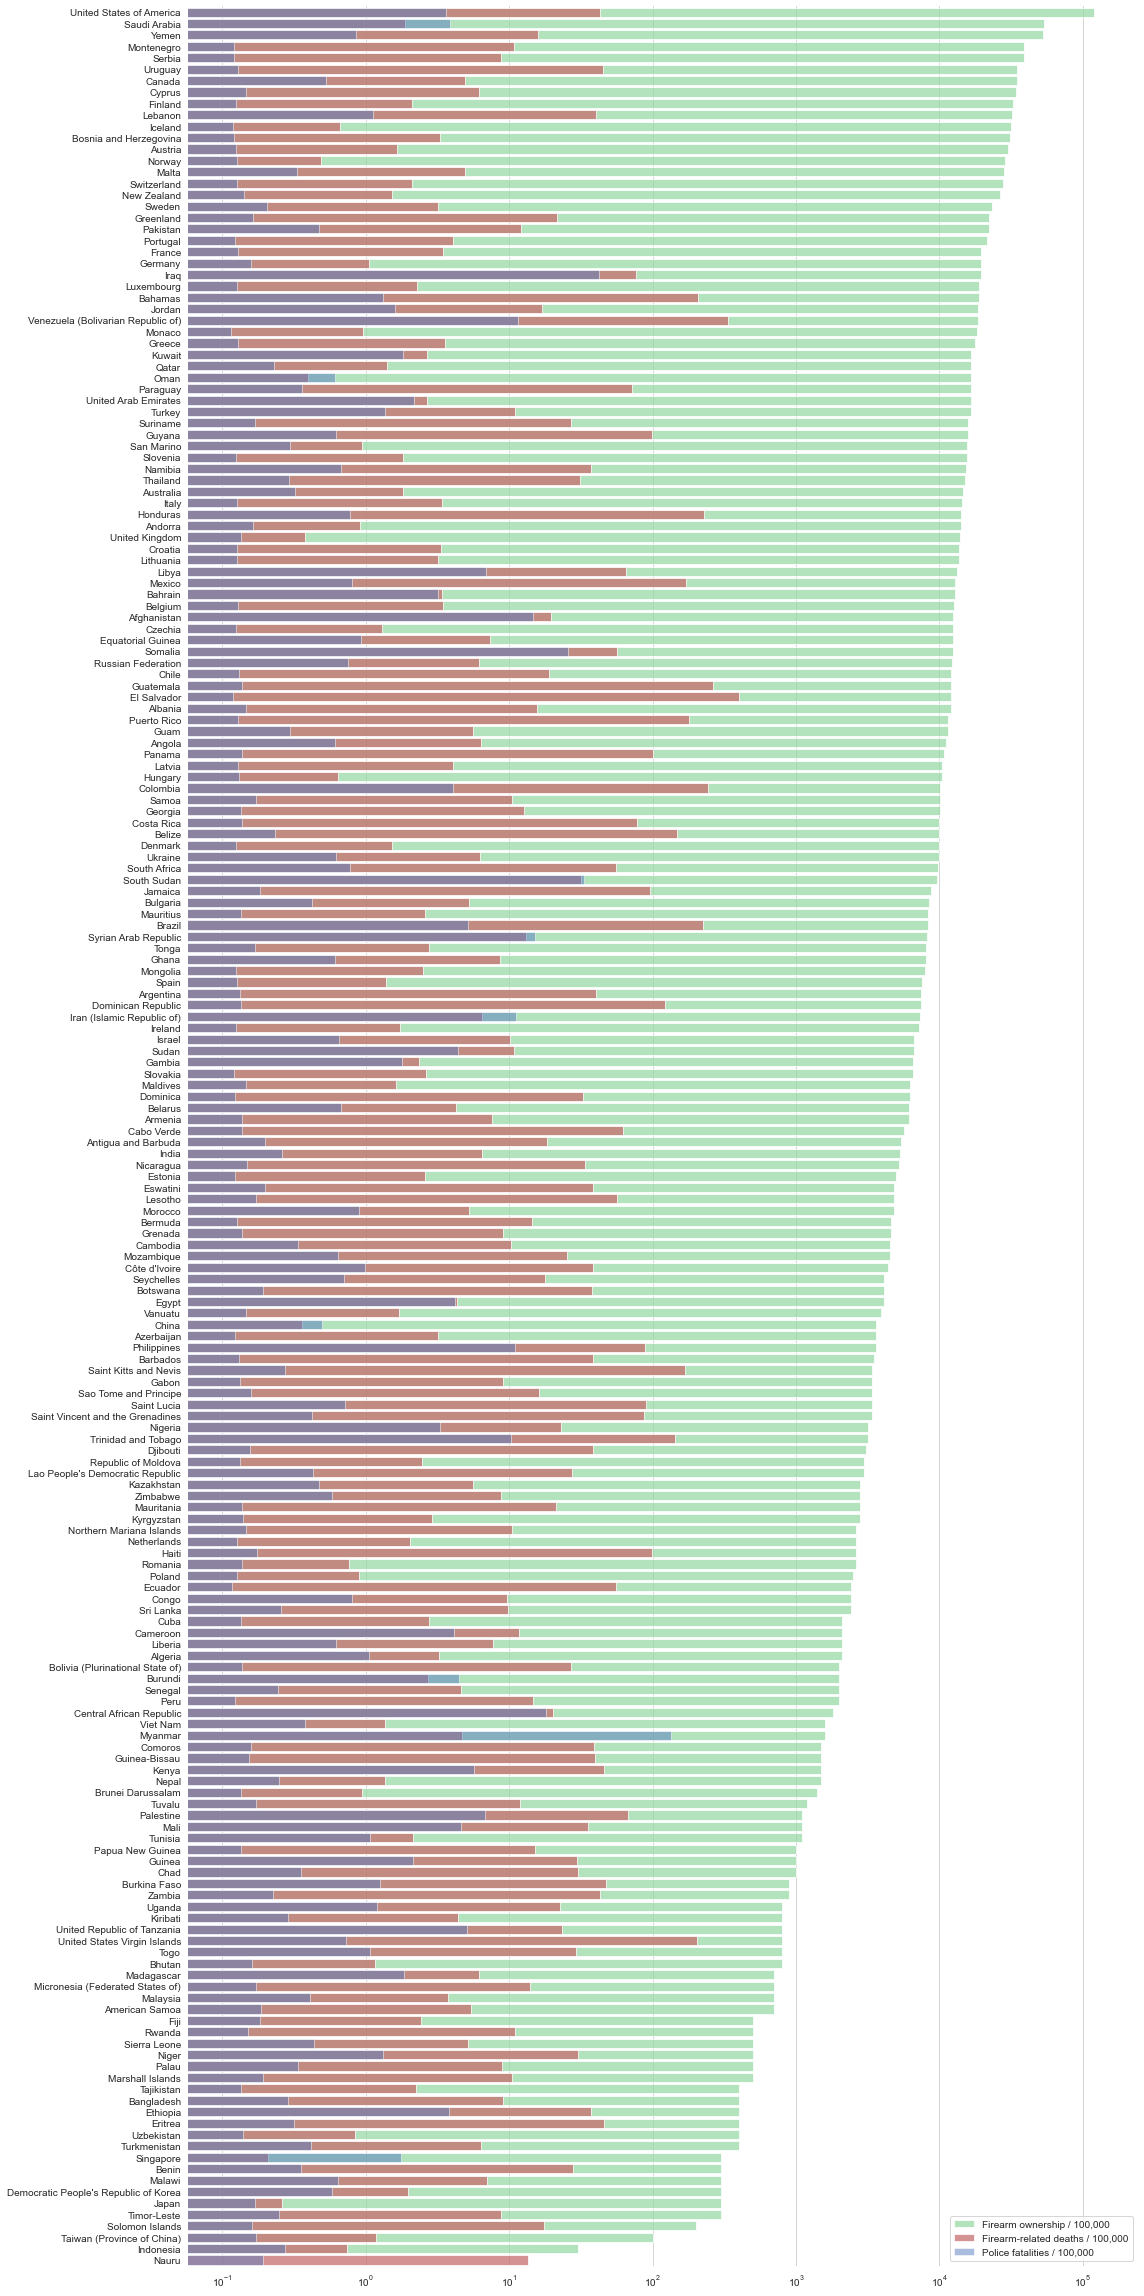

In [7]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(16,32))
sns.set_color_codes("pastel")
sns.barplot(x='firearm-ownership_rate', y='country_code', data=df_ownership_deaths,
            label="Firearm ownership / 100,000", color="g", alpha=0.75,
            dodge=0.5)

sns.set_color_codes("muted")
sns.barplot(x="violence-firearm_rate", y="country", data=df_ownership_deaths,
            label="Firearm-related deaths / 100,000", color="r", alpha=0.75,
           dodge=True)

# sns.set_color_codes("muted")
sns.barplot(x="police_rate", y="country", data=df_ownership_deaths,
            label="Police fatalities / 100,000", color="b", alpha=0.5,
           dodge=True)
# Add a legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="")
sns.despine(left=True, bottom=True)

ax.set_xscale('log')
plt.tight_layout()
plt.savefig('figures/countries_barplot.png', dpi=300)
# ax.set_xlim((3e-3,35))
# fig, ax = plt.subplots(figsize=(8,40))
# df_fi.sort_values(by='firearm_frac', ascending=False).set_index('country_code')[["firearm_frac", "violence-firearm_frac", "police_frac"]].plot.barh(ax=ax)

The first thing to note is that there is no significant trend between gun ownership and deaths. A significant portion of high-ranked countries in terms of gun-ownership demonstrate orders of magnitude lower rates compared to, for example, the US, which has the highest number of guns per capita, or other lower-ranked countries.

This is not unexpected, as countries of the world are extremely diverse and have their specific laws, politics, culture, stability that may drive the firearm and police death rates much more than the simple rate of firearm ownership.

So let's plug in the freedom indices in the analysis in hopes for further insight.

#### Question 2: Are there trends in the death rates by firearm and police with respect to how developed a country is?

As a proxy for how developed a country is, I'll be using the freedom index values, in particular personal freedom. I have chosen personal freedom over economic freedom (or the overall human freedom index which takes into account both), mostly because the justification for the high rate of firearm ownership in the US comes from the Second Amendement, which is closely related to individual liberty and prevention of "an over-reaching federal government".

For this part of the analysis, since we're using all three sources of data, let's clean up the set and drop any nan values:

In [8]:
df_fi = df.dropna()

Next we'll use a scatter plot that depicts several of the available columns at once. We'll put the personal freedom index (PFI) on the y axis and log the firearm ownership rate in the point sizes. We're interested in the firearm and police death rates, so we'll make two separate plots: one with firearm death rate on the x-axis and police death rate logged in the colormap, and the opposite: police death rate on the x-axis and firearm death rate as the colormap. This should give us sufficient information to draw conclusions on whether trends exist in any of these values with respect to the personal freedom index.

**firearm death rate**

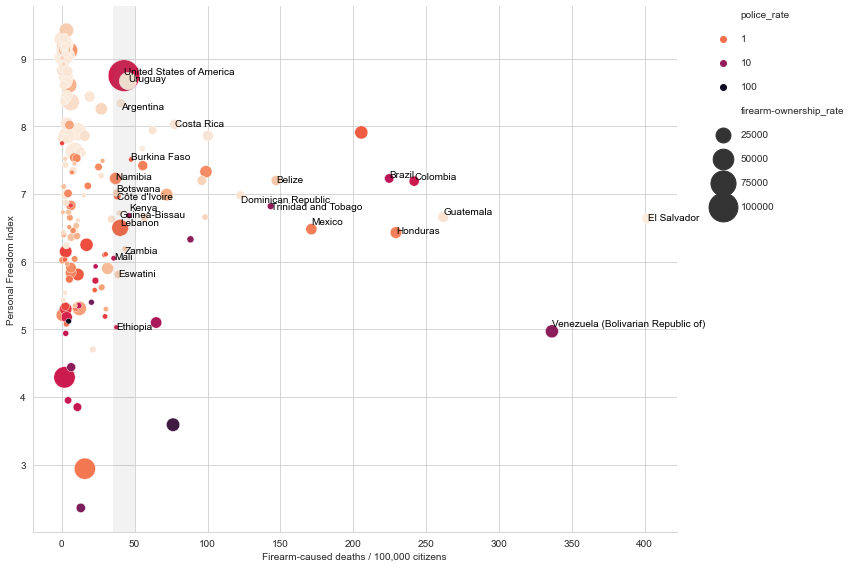

In [9]:
import matplotlib.colors as colors
plt.figure(figsize=(12,8))
np.random.seed(42)
sns.scatterplot(data=df_fi, x='violence-firearm_rate', y='pf_score', 
                hue='police_rate', palette='rocket_r',
                size='firearm-ownership_rate', sizes=(20, 1000),
                hue_norm=colors.LogNorm())
for country_code in df_fi['country_code'][ ((df_fi['violence-firearm_rate'] > 100) &
                                            (df_fi['pf_score'] < 7.5))
                                         | ((df_fi['violence-firearm_rate'] > 40) & 
                                            (df_fi['pf_score'] > 8))
                                         | ((df_fi['violence-firearm_rate'] < 50) &
                                            (df_fi['violence-firearm_rate'] > 35))]:
    plt.text(x=df_fi['violence-firearm_rate'][df_fi.country_code==country_code].values[0]+0.1,
             y=df_fi['pf_score'][df_fi.country_code==country_code].values[0]+0.001+np.random.normal(0,0.05),
             s=df_fi['country'][df_fi.country_code==country_code].values[0],
             fontdict=dict(color='black',size=10),
         )
sns.despine(right=True, top=True)
plt.axvspan(35, 50, color='grey', alpha=0.1, lw=0)
# plt.xlim(0,0.15)
# plt.xscale('log')
plt.xlabel('Firearm-caused deaths / 100,000 citizens')
plt.ylabel('Personal Freedom Index')
plt.legend(scatterpoints=1, ncol=1, markerscale=1, frameon=False, labelspacing=1.5, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig('figures/firearms_pf.png', dpi=300)

What can we deduct from the above plot?
- countries with PFI > 8 show overall larger firearm ownership rates, but overall lowest firearm caused deaths
- the largest range of firearm-caused deaths (and highest recorded values) fall in between 6 < PFI < 8.
- many countries with PFI < 6 have higher firearm ownership, but lower firearm death rates compared 6 < PFI < 8 countries.
- the police rate is lowest in countries with PFI > 8, with the exception of USA.

**police death rate**

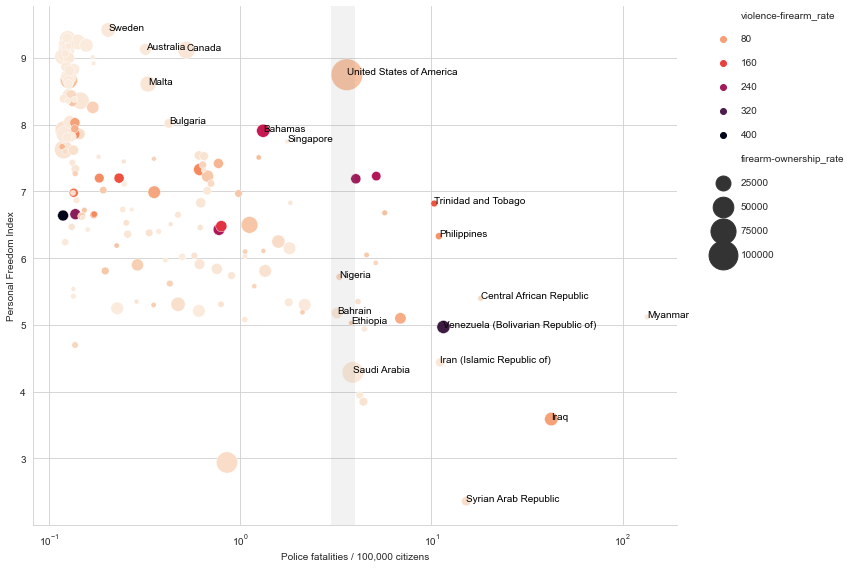

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
p = sns.scatterplot(data=df_fi, x='police_rate', y='pf_score', 
                hue='violence-firearm_rate', 
                size='firearm-ownership_rate', sizes=(20, 1000),
                palette='rocket_r', ax=ax)
np.random.seed(41)
mask =  ((((df_fi['police_rate'] > 3) & (df_fi['police_rate'] < 4) & (df_fi['pf_score'] < 7.7))
          | (df_fi['police_rate'] > 10)
         | ((df_fi['police_rate'] > 0.2) & (df_fi['pf_score'] > 7.7))))

for country_code in df_fi['country_code'][mask]:
    ax.text(x=df_fi['police_rate'][mask][df_fi.country_code==country_code].values[0]+0.001,
             y=df_fi['pf_score'][mask][df_fi.country_code==country_code].values[0]+0.0001,
             s=df_fi['country'][mask][df_fi.country_code==country_code].values[0],
             fontdict=dict(color='black',size=10),
         )
    
# ax.set_xlim((-0.01,0.125))
sns.despine(right=True, top=True)
ax.axvspan(3, 4, color='grey', alpha=0.1, lw=0)
ax.set_xscale('log')
plt.legend(scatterpoints=1, ncol=1, markerscale=1, frameon=False, labelspacing=1.5, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Police fatalities / 100,000 citizens')
plt.ylabel('Personal Freedom Index')
plt.tight_layout()
plt.savefig('figures/police_pf.png', dpi=300)

We used a log-scale for the x-axis on this plot to account for the vast range of several orders of magnitude recorded in the police death rates.

Did this plot uncover any new information that the previous one didn't? It looks like it just solidified the distinction in the three groups based on PFI, with PFI > 8 countries showing lowest rates of police deaths and PFI < 6 the highest, while 6 < PFI < 8 countries occupy a wide range of values both in firearm and police deaths.

We can use this information to refine our analysis when answering the last question.

#### Does firearm ownership grant more personal freedom?

The simplest way to answer this question through data is to look at the correlation index between the firearm ownership rates and freedom indices.

The below plots show the correlation indices computed with three different methods: Pearson, Kendall and Spearman. Let's try to break down what they measure here and choose which one to use moving forward.

The Pearson correlation coefficient measures the degree of **linear correlation** between two variables. The Kendall and Spearman methods both measures of **rank correlation**, meaning they do not directly measure the correlation of the variable values, but instead their ranks. The Spearman coefficient is essentially the Pearson coefficient computed for rank variables.

The Pearson and Spearman coefficients are relatively intuitive to understand. Pearson measures if a linear relationship can be estabilished between the two variables, while Spearman measures if a monotonic relationship can be estabilished (not necessarily linear!). 

As such, *Pearson is much more sensitive to outliers compared to Spearman*. 

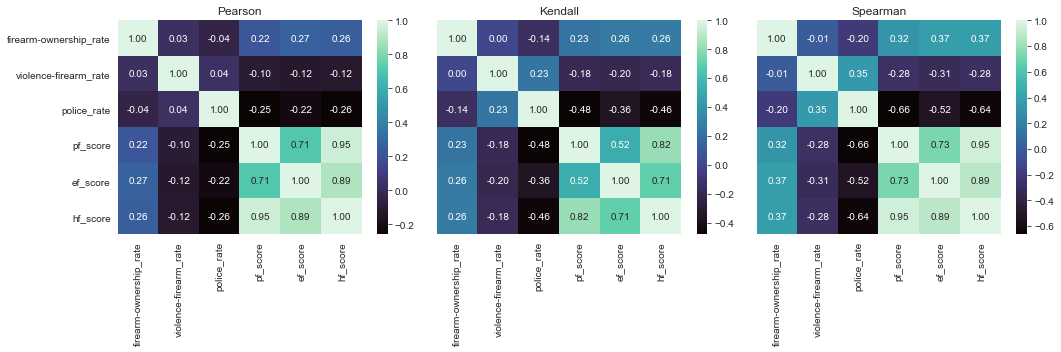

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

sns.heatmap(df_fi[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method='pearson'), annot=True, fmt=".2f", cmap='mako', ax=axes[0])
sns.heatmap(df_fi[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method='kendall'), annot=True, fmt=".2f", cmap='mako', ax=axes[1])
sns.heatmap(df_fi[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method='spearman'), annot=True, fmt=".2f", cmap='mako', ax=axes[2])
axes[1].set_yticks([])
axes[2].set_yticks([])
axes[0].set_title('Pearson')
axes[1].set_title('Kendall')
axes[2].set_title('Spearman')
plt.tight_layout()
# plt.savefig('figures/heatmaps_pfcategories.png', dpi=300)
plt.show()


We immediately see that all freedom indices are highly correlated, which is expected: the human freedom score (hf_score) is computed taking into account the personal (pf_score) and economic (ef_score) scores, so it's highly correlated with both. A country with high EFI is also more likely to have high PFI so the two are also significantly correlated.

As for the rest of the columns, there is no strong indication of correlation. The firearm ownership rate seems to be somewhat positively correlated with the freedom indices, but it's not a strong enough correlation with any one of the three methods to warrant any conclusive answer to the question.

So what else can we do?

Earlier we noticed three distinct groups in terms of PFI, that fall roughly within the ranges: PFI>8, 6<PFI<8 and PFI<6. Let's split the data according to this grouping into countries with high, medium and low PFI and plot the heatmap of feature correlations to see if there are any differences between the groups.

As we've seen in the previous section, USA is a significant outlier among the high PFI countries in all of the three categories of interest. So the decision we need to make now is whether we want the outliers to impact the result or not. 

I have chosen to initially use the Spearman coefficient to test for any monotonic and not necessarily linear relationship between the variables across the three PFI groups. I will then use the Pearson coefficient on the high PFI group with and without USA to see how USA, as an outlier, affects the correlation index.

In [32]:
corr_method='spearman'

In [33]:
df_high_pfi = df_fi[df_fi['pf_score'] > 8]
df_med_pfi = df_fi[(6 <= df_fi['pf_score']) & (df_fi['pf_score'] <= 8)]
df_low_pfi = df_fi[df_fi['pf_score'] < 6]

Text(0.5, 1.0, 'Correlation of variables with firearm ownership rate')

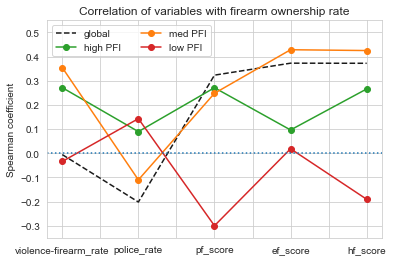

In [84]:
df_fi[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method=corr_method)['firearm-ownership_rate'][1:].plot(color='k', ls='--', label='global')
df_high_pfi[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method=corr_method)['firearm-ownership_rate'][1:].plot(color='C2', marker='o', label='high PFI')
df_med_pfi[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method=corr_method)['firearm-ownership_rate'][1:].plot(color='C1', marker='o', label='med PFI')
df_low_pfi[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method=corr_method)['firearm-ownership_rate'][1:].plot(color='C3', marker='o', label='low PFI')
plt.legend(ncol=2, loc='upper left')
plt.ylim(-0.35,0.55)
plt.ylabel('Spearman coefficient')
plt.axhline(y=0, c='C0', ls=':')
plt.title('Correlation of variables with firearm ownership rate')

The above plot shows the Spearman correlation coefficient for each variable and the firearm ownership rate. We can see that the medium PFI countries are mostly responsible for the overall global trend, which makes sense because there are almost twice as many countries in the medium PFI group as there are in the other two.

One interesting thing that we can note in the above plot is that there seems to be an almost inverse trend between the high and low PFI countries, in particular in terms of the personal freedom score. Firearm ownership is somewhat correlated with PFI for high PFI countries (correlation coefficient ~ 0.3), while it is anti-correlated to a similar extent for low PFI countries (correlation coefficient ~ -0.3). This indicates that gun ownership **may** ensure freedom only in more developed countries. 

The other interesting observation comes in the rates of firearm and police fatalities between different groups. For both high and medium PFI countries, firearm ownership and violence are somewhat correlated, while police fatalities less so. The situation in low PFI countries is the opposite: there is no correlation between firearm ownership and violence, but police fatalities show a higher correlation coefficient compared to the high and medium PFI group.

**What about the United States?**

Let's look at the high PFI group in more detail now to determine if it follows the overall trends of the group. Instead of just using a correlation coefficient, we'll look at a correlation plot:

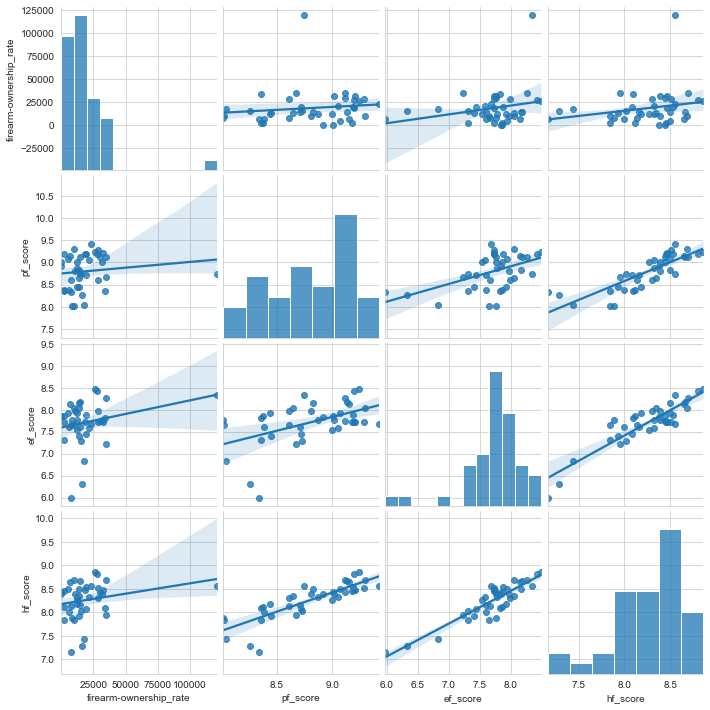

In [88]:
sns.pairplot(df_high_pfi[['firearm-ownership_rate', 'pf_score', 'ef_score', 'hf_score']], kind="reg")
plt.show()

We immediately notice that there is one strong outlier in both the firearm ownership and police violence rates. And we already know for the scatter plots that the point corresponds to the US. If we look at the resulting linear relationships, in the firearm ownership rate plots, it's immediately evident that the outlier is driving the overall positive slope, which would result in a high positive Pearson coefficient. So what happens to the Pearson coefficient if we remove the US from the data set? Here's the result:

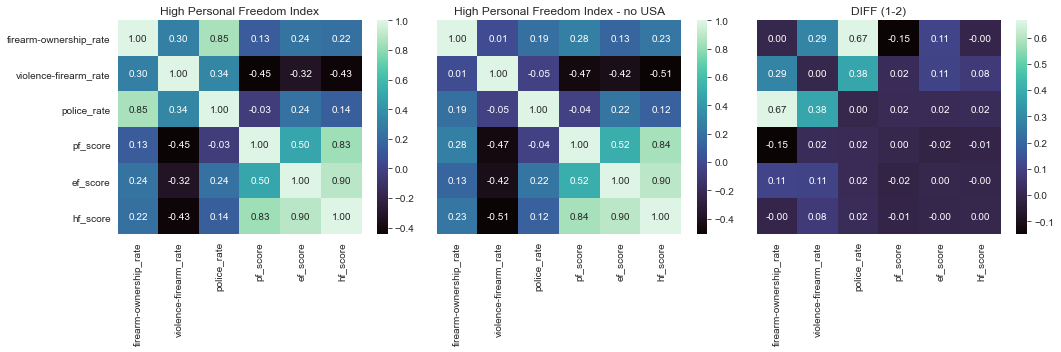

In [91]:
df_high_pfi_nousa = df_high_pfi.drop(df_high_pfi[df_high_pfi['country_code']=='USA'].index, axis=0)
corr_method='pearson'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

sns.heatmap(df_high_pfi[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method=corr_method), annot=True, fmt=".2f", cmap='mako', ax=axes[0])
sns.heatmap(df_high_pfi_nousa[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method=corr_method), annot=True, fmt=".2f", cmap='mako', ax=axes[1])
sns.heatmap(df_high_pfi[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method=corr_method)-df_high_pfi_nousa[['firearm-ownership_rate', 'violence-firearm_rate', 'police_rate', 
                        'pf_score', 'ef_score', 'hf_score']].corr(method=corr_method), annot=True, fmt=".2f", cmap='mako', ax=axes[2])
axes[1].set_yticks([])
axes[2].set_yticks([])
axes[0].set_title('High Personal Freedom Index')
axes[1].set_title('High Personal Freedom Index - no USA')
axes[2].set_title('DIFF (1-2)')
plt.tight_layout()
# plt.savefig('figures/heatmaps_hpf_usa.png', dpi=300)
plt.show()

That's a significant change! Both the firearm and police fatalities show significant decrease in the correlation coefficient after removing the US! But the correlation coefficient between firearm ownership and personal freedom more than doubles.

So what can we conclude from this? Compared to similarly developed countries, the high firearm ownership rate in the US seems to be related significantly to the high firearm violence and high police fatalities rates, but not as much to the personal freedom index! 

#### Final conclusions
- There are no clear correlations between firearm ownership, firearm-caused deaths and police-caused deaths on a global level. This is understandable because a lot of these incidents are driven by the laws, politics, economy and stability within a country and these differ greatly on a global scale.
- Firearm-caused deaths show the widest range in medium-PFI countries (6 < PFI < 8), while police-caused deaths are highest for low-PFI (PFI < 6) countries. This is logical if we take into account access to firearms and political instabilities in both of these groups.
- USA is a clear outlier in all of these categories within the high PFI group. Its firarm-caused death rates are closer to the mid-PFI countries (with much lower firearm ownership rates), while police-caused death rates fall on the boundary of the values spanned by mid-PFI and low-PFI countries.
- **The firearm ownership rate in the US does not follow similar trends as the rest of the countries with high PFI. Its removal from the dataset significantly decreases the correlation between firearm ownership and firearm/police fatalities, but slightly increases the correlation between firearm ownership and personal freedom.**

Because the US is such a significant outlier, it is not feasible to use the world as a model for the causes and rates of firearm and police violence observed in the US. Instead, we need a model for the US alone only, for which we'll use data from each state to determine the potential existence of trends that can be useful as the basis of a linear regression model.